In [1]:
import glob
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import seaborn as sns

pi = 3.14159265359
maxval = 1e9
minval = 1e-9

In [2]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [3]:
X_train = pd.read_csv("../data/1D/X.csv").values
y_train = pd.read_csv("../data/1D/y.csv")
X_test = pd.read_csv("../data/1D/test/reconTest_1Dx.csv").values
y_test = pd.read_csv("../data/1D/test/labelsTest.csv")


y_train = inverse_cot(abs(y_train['cotAlpha'].values))*2/pi
y_test = inverse_cot(abs(y_test['cotAlpha'].values))*2/pi

X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(1003587, 21) (1003587,) (125498, 21) (125498,)


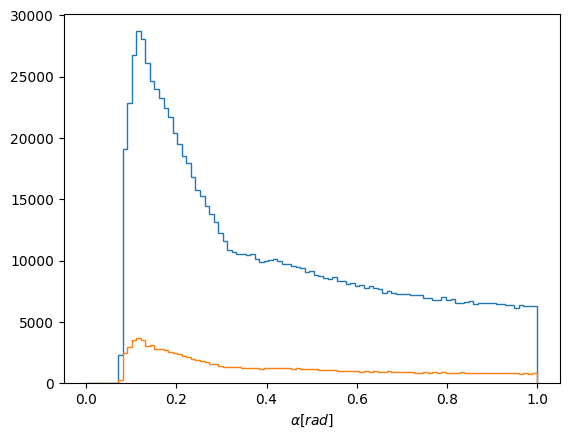

In [4]:
plt.hist(y_train,bins=np.linspace(0,1,100), histtype = 'step')
plt.hist(y_test,bins=np.linspace(0,1,100), histtype = 'step')
plt.xlabel(r'$\alpha [rad]$')
plt.show()

In [5]:
def param_transform(par):
    return minval+tf.math.softplus(par)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                  concentration0 = beta)
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)    

In [6]:
class AlphaModel1D:

    def build(self,inputs):
        x = keras.layers.Dense(64, 
                               name = "hidden_i")(inputs)
        x = keras.layers.Activation(activation = 'elu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(64, 
                               name = "hidden_ii")(x)
        x = keras.layers.Activation(activation = 'elu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(64, 
                               name = "hidden_iii")(x)
        x = keras.layers.Activation(activation = 'elu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(2,
                               name = "final_output")(x)

        return x
 
    def assemble_model(self, input_dim):
        inputs = keras.layers.Input ( shape = input_dim)
        outputs = self.build(inputs)
        model = keras.models.Model(inputs =[inputs], 
                      outputs=outputs, 
                      name = "cotAlpha_1D_x_profile_model")
        return model
    
model = AlphaModel1D().assemble_model(input_dim=X_train.shape[1:])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=beta_loss)

model.summary()

Metal device set to: Apple M1
Model: "cotAlpha_1D_x_profile_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 hidden_i (Dense)            (None, 64)                1408      
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 hidden_ii (Dense)           (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
         

2023-02-09 13:33:49.417803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-09 13:33:49.417822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
es = keras.callbacks.EarlyStopping(patience=20,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=1000, 
                    batch_size=512,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2023-02-09 13:33:49.621400: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2023-02-09 13:33:50.059825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1569/1569 [==============================] - ETA: 0s - loss: -1.1702

2023-02-09 13:34:24.535850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1569/1569 [==============================] - 39s 24ms/step - loss: -1.1702 - val_loss: -1.5765
Epoch 2/1000
1569/1569 [==============================] - 37s 24ms/step - loss: -1.6143 - val_loss: -1.7332
Epoch 3/1000
1569/1569 [==============================] - 37s 24ms/step - loss: -1.7212 - val_loss: -1.8303
Epoch 4/1000
1569/1569 [==============================] - 37s 24ms/step - loss: -1.7897 - val_loss: -1.8864
Epoch 5/1000
1569/1569 [==============================] - 37s 24ms/step - loss: -1.8464 - val_loss: -1.9276
Epoch 6/1000
1569/1569 [==============================] - 37s 24ms/step - loss: -1.8923 - val_loss: -1.9684
Epoch 7/1000
1569/1569 [==============================] - 38s 24ms/step - loss: -1.9297 - val_loss: -2.0096
Epoch 8/1000
1569/1569 [==============================] - 37s 24ms/step - loss: -1.9625 - val_loss: -2.0277
Epoch 9/1000
1569/1569 [==============================] - 37s 24ms/step - loss: -1.9844 - val_loss: -2.0279
Epoch 10/1000
1569/1569 [================

1569/1569 [==============================] - 39s 25ms/step - loss: -2.3199 - val_loss: -2.3807
Epoch 77/1000
1569/1569 [==============================] - 42s 27ms/step - loss: -2.3233 - val_loss: -2.3704
Epoch 78/1000
1569/1569 [==============================] - 39s 25ms/step - loss: -2.3207 - val_loss: -2.3702
Epoch 79/1000
1569/1569 [==============================] - 39s 25ms/step - loss: -2.3170 - val_loss: -2.3785
Epoch 80/1000
1569/1569 [==============================] - 40s 25ms/step - loss: -2.3226 - val_loss: -2.3749
Epoch 81/1000
1569/1569 [==============================] - 39s 25ms/step - loss: -2.3261 - val_loss: -2.3621
Epoch 82/1000
1569/1569 [==============================] - 38s 24ms/step - loss: -2.3234 - val_loss: -2.3828
Epoch 83/1000
1569/1569 [==============================] - 38s 24ms/step - loss: -2.3289 - val_loss: -2.3193
Epoch 84/1000
1569/1569 [==============================] - 40s 25ms/step - loss: -2.3291 - val_loss: -2.2997
Epoch 85/1000
1569/1569 [========

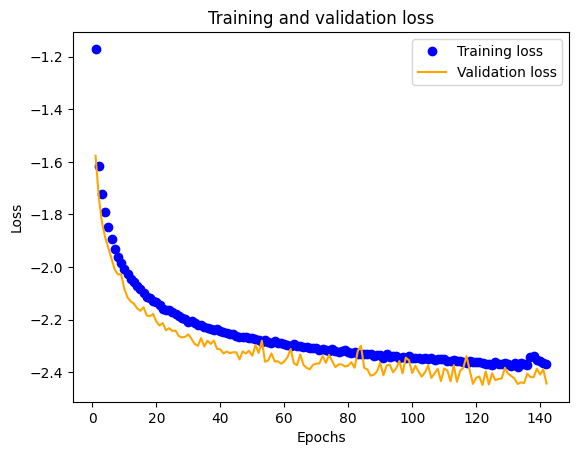

In [8]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [9]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Atrue'] = y_test*pi/2
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])

dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
df['mean'] = dist.mean()*pi/2
df['mode'] = dist.mode()*pi/2
df['sigma'] = dist.stddev()*pi/2

  26/3922 [..............................] - ETA: 16s

2023-02-09 15:03:36.769312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3922/3922 [==============================] - 16s 4ms/step


In [10]:
residuals = df['Atrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

-0.01072454397238653 0.07858033870564701


/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_15931/2291133400.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


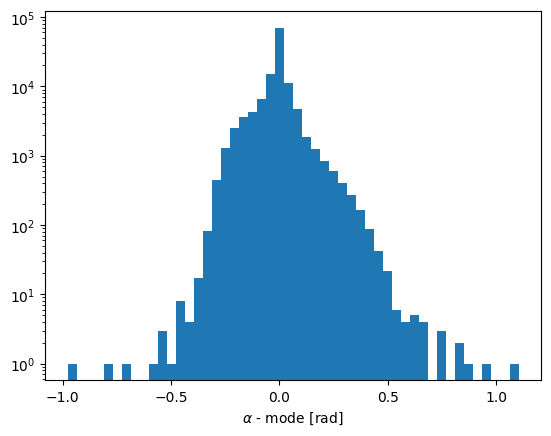

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_15931/2291133400.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


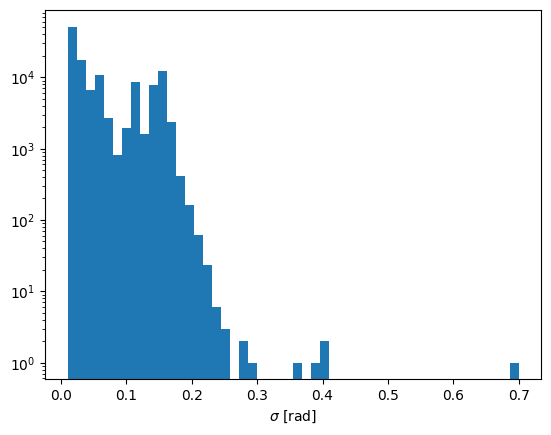

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_15931/2291133400.py:12: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


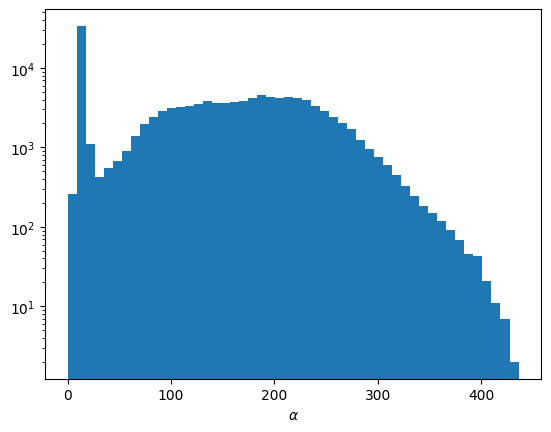

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_15931/2291133400.py:17: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


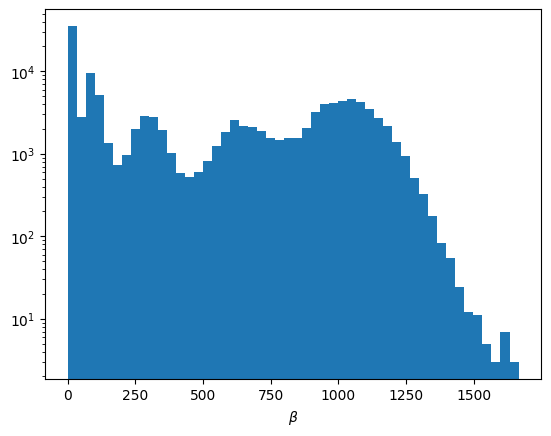

In [11]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$ - mode [rad]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(df['alpha'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$')
plt.show()

plt.hist(df['beta'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$')
plt.show()

Text(0, 0.5, 'log(beta)')

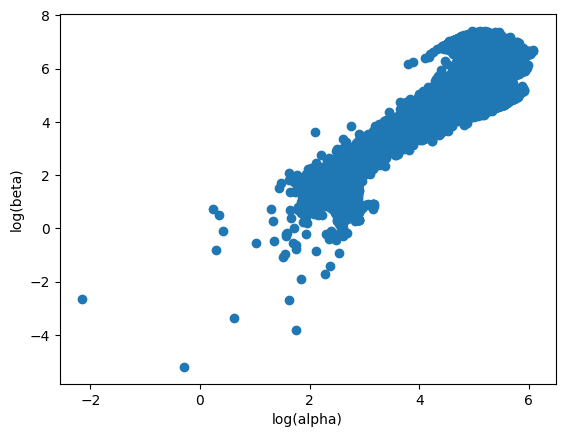

In [12]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

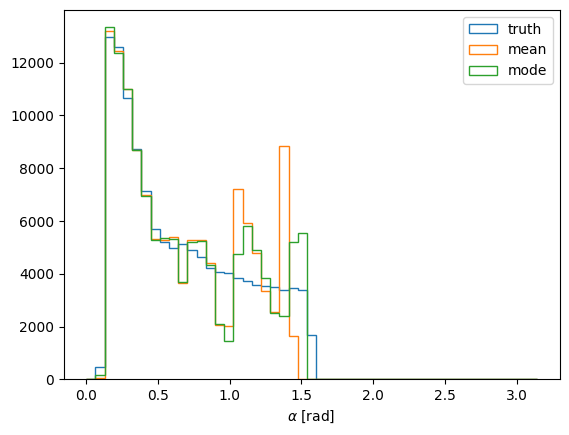

In [13]:
plt.hist(df['Atrue'],bins=np.linspace(0,pi,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(0,pi,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(0,pi,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
plt.legend()
plt.show()

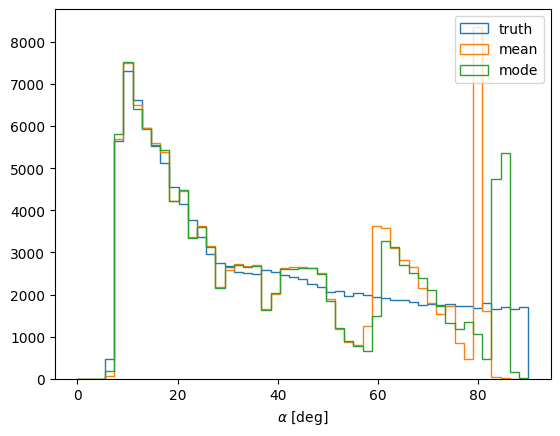

In [14]:
plt.hist(df['Atrue']*180/pi,bins=np.linspace(0,90,50),histtype='step',label='truth')
plt.hist(df['mean']*180/pi,bins=np.linspace(0,90,50),histtype='step',label='mean')
plt.hist(df['mode']*180/pi,bins=np.linspace(0,90,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\alpha$ [deg]')
plt.legend()
plt.show()

Text(0, 0.5, '$\\alpha$ - mode [rad]')

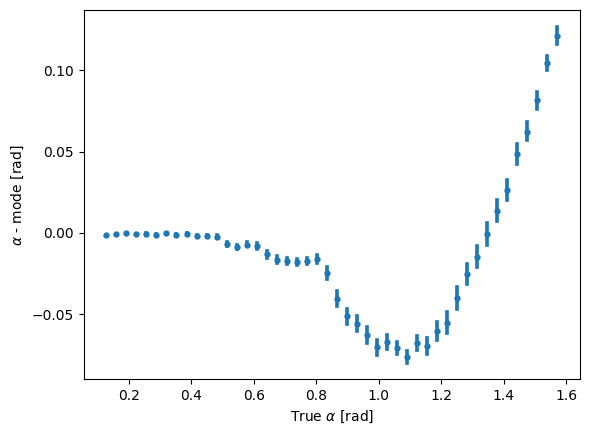

In [15]:
x = sns.regplot(x=df['Atrue'], y=residuals, x_bins=np.linspace(0,pi/2,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [rad]')
plt.ylabel(r'$\alpha$ - mode [rad]')

Text(0, 0.5, '$\\sigma$ [rad]')

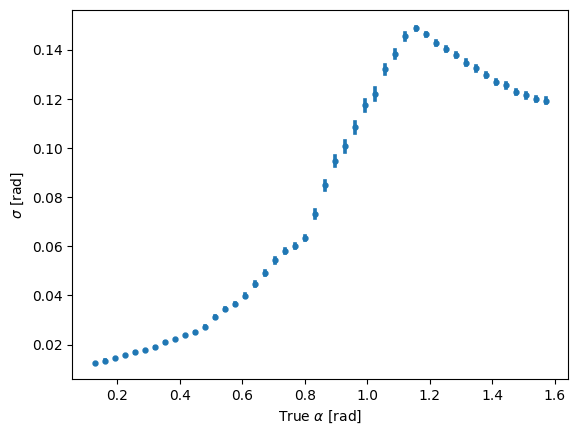

In [16]:
y = sns.regplot(x=df['Atrue'], y=df['sigma'], x_bins=np.linspace(0,pi/2,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')

-0.09341487617251332 0.8514202362028861


Text(0.5, 0, 'pull')

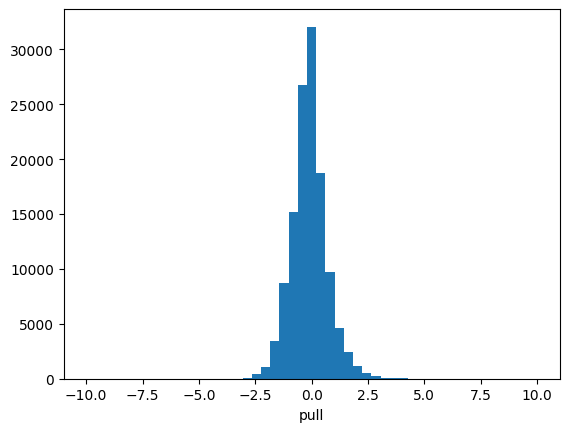

In [17]:
pulls = residuals/df['sigma']
print(np.mean(pulls),np.std(pulls))

plt.hist(pulls,bins=np.linspace(-10,10,50))
plt.xlabel('pull')